In [1]:
%pylab inline
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import operator
import pickle
from pprint import pprint
import re
import string
import seaborn as sns
sns.set(color_codes=True)

# Import all of the sklearn stuff
import sklearn
from sklearn.decomposition import TruncatedSVD
# from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.preprocessing import Normalizer
from sklearn import metrics
# from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Sentiment
from textblob import TextBlob
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.lancaster import LancasterStemmer
#from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


# Not being used
# gensim modules
# from gensim.parsing.preprocessing import STOPWORDS
# from gensim.models import TfidfModel, LsiModel
# from gensim.models.ldamodel import LdaModel
# from gensim import corpora
# from gensim import matutils
# # from gensim.utils import simple_preprocess

# # misc modules
# import pyLDAvis.gensim as gensimvis
# import pyLDAvis
# from sklearn.cluster import KMeans
# from sklearn.decomposition import NMF, LatentDirichletAllocation

Populating the interactive namespace from numpy and matplotlib


/Users/jas/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Load, Process, Filter News Articles

In [2]:
df_news = pd.read_csv('~/ds/data/nlp/news-week-aug24.csv', encoding='UTF-8')
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1398431 entries, 0 to 1398430
Data columns (total 4 columns):
publish_time     1398431 non-null int64
feed_code        1398431 non-null object
source_url       1398431 non-null object
headline_text    1397447 non-null object
dtypes: int64(1), object(3)
memory usage: 42.7+ MB


In [3]:
#Removes front and end punctuation, makes all lower case, removes empty strings.
def clean_news(article):    
    return ' '.join([w.lower().strip().rstrip(string.punctuation)\
        .lstrip(string.punctuation).strip()\
        for w in article.split()\
        if w.strip().rstrip(string.punctuation).strip()])

# function to force to 'None' if error in cleaning on following step
def try_clean(text):
    try:
        w = clean_news(text)
        return(w)
    except:
        return(None)

# clean the headlines
pre_filter = []

for x in df_news.headline_text:
    pre_filter.append(try_clean(x))
    
len(pre_filter)

1398431

In [4]:
# return list of indicies with 'None' values (for whatever reason) that we will drop from 'df_news'
drop_inds = []
for ind, x in enumerate(pre_filter):
    if x is None:
        drop_inds.append(ind)
        
# drop from df_news
df_news = df_news[~df_news.index.isin(drop_inds)]
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1397447 entries, 0 to 1398430
Data columns (total 4 columns):
publish_time     1397447 non-null int64
feed_code        1397447 non-null object
source_url       1397447 non-null object
headline_text    1397447 non-null object
dtypes: int64(1), object(3)
memory usage: 53.3+ MB


In [5]:
# below separates 'None'-filtered list from df, which is not ideal as it is repeated a step... but it works.
pre_filter2 = [x for x in pre_filter if x is not None]

# apply Amazon filter
filter_list = ['bezos','amazon','amzn','hq2', 'alexa', 'audible', 'zappos','goodreads', 'jeffbezos', 'whole foods']

filtered_indys = []

for x in filter_list:
    for indy, y in enumerate(pre_filter2):    # could probably also use .map or .apply and lambda here to work
        if x in y:                           # directly on the DF
            filtered_indys.append(indy)

df_amznnews = df_news.iloc[filtered_indys]
df_amznnews.sample(10)

,publish_time,feed_code,source_url,headline_text
144552,201708241527,w3-thestreet,https://www.thestreet.com/story/14282927/1/ftc...,FTC Greenlights Amazon's $13.7 Billion Whole F...
899556,201708281701,w3-naharnet,http://www.naharnet.com/stories/en/234465-goog...,Google and Walmart Team Up to Take on Amazon
235797,201708242241,w3-livetradingnews,http://www.livetradingnews.com/amazon-nasdaqam...,Amazon (NASDAQ:AMZN) Will Now Sell &#8216;Whol...
609729,201708262233,w3-koco,http://www.koco.com/article/amazon-we-re-lower...,Amazon: We're lowering Whole Foods prices on M...
248679,201708250002,w3-newson6,http://www.newson6.com/story/36210885/amazon-t...,Amazon to cut prices on Whole Foods staples li...
132739,201708241433,w3-francebleu-fr,https://www.francebleu.fr/infos/international/...,Amazonie : des millions d'hectares de forêt ou...
11269,201708240107,w3-businessinsider,http://www.businessinsider.com/amazon-stock-pr...,The Amazon-Whole Foods deal has received the g...
910135,201708281754,w3-ctvnews-ca,http://www.ctvnews.ca/business/it-s-a-done-dea...,It's a done deal: Amazon takes over Whole Foods
907227,201708281738,w3-seattletimes-nwsource,http://www.seattletimes.com/business/its-a-don...,It's a done deal: Amazon takes over Whole Foods
934979,201708281956,w3-sunherald,http://www.sunherald.com/news/business/article...,"Now at Whole Foods: Cheaper milk, 'farm fresh'..."


In [6]:
# convert 'publish_time' to datetime format
df_amznnews['publish_time'] = df_amznnews['publish_time'].astype(str)
df_amznnews['publish_time'] = pd.to_datetime(df_amznnews['publish_time'], format='%Y%m%d%H%M')
df_amznnews.info()
# the big 'Y' was key to making the 'to_datetime()' work

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6459 entries, 769 to 1397573
Data columns (total 4 columns):
publish_time     6459 non-null datetime64[ns]
feed_code        6459 non-null object
source_url       6459 non-null object
headline_text    6459 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 252.3+ KB


/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Sentiment on AMZN Headlines
textblob_list = []
for title in df_amznnews.headline_text:
    x = TextBlob(title).sentiment.polarity
    textblob_list.append(x)

df_amznnews['textblob_sent'] = textblob_list
df_amznnews.info()

sid = SentimentIntensityAnalyzer()

vader_list = []

for title in df_amznnews.headline_text:
    ss = sid.polarity_scores(title)
    vader_list.append(ss)

# confirmed - returns dataframe with vader_sent correctly aligned with headlines (iffy when adding new column as list)
df_amznnews['vader_sent'] = vader_list


# Create separate columns for each Vader Sentiment key.
vs_neg_list = [x['neg'] for x in df_amznnews.vader_sent]
vs_neu_list = [x['neu'] for x in df_amznnews.vader_sent]
vs_pos_list = [x['pos'] for x in df_amznnews.vader_sent]
vs_compound_list = [x['compound'] for x in df_amznnews.vader_sent]

# Add lists to dataframe.
df_amznnews['vs_neg'] = vs_neg_list
df_amznnews['vs_neu'] = vs_neu_list
df_amznnews['vs_pos'] = vs_pos_list
df_amznnews['vs_compound'] = vs_compound_list

# Show it off.
df_amznnews.info()

/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6459 entries, 769 to 1397573
Data columns (total 5 columns):
publish_time     6459 non-null datetime64[ns]
feed_code        6459 non-null object
source_url       6459 non-null object
headline_text    6459 non-null object
textblob_sent    6459 non-null float64
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 302.8+ KB


/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6459 entries, 769 to 1397573
Data columns (total 10 columns):
publish_time     6459 non-null datetime64[ns]
feed_code        6459 non-null object
source_url       6459 non-null object
headline_text    6459 non-null object
textblob_sent    6459 non-null float64
vader_sent       6459 non-null object
vs_neg           6459 non-null float64
vs_neu           6459 non-null float64
vs_pos           6459 non-null float64
vs_compound      6459 non-null float64
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 555.1+ KB


/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Join with Stock data

In [8]:
df_tick = pd.read_pickle('tweet_data/amzn_ohlcv_may18.pkl')
df_tick.set_index(df_tick.index.to_datetime(), inplace=True)
df_tick.info()

/Users/jas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4632 entries, 2000-01-03 to 2018-05-31
Data columns (total 5 columns):
1. open      4632 non-null float64
2. high      4632 non-null float64
3. low       4632 non-null float64
4. close     4632 non-null float64
5. volume    4632 non-null float64
dtypes: float64(5)
memory usage: 217.1 KB


In [9]:
# reduce graph data size
df_tick = df_tick.loc['2017-08-24':'2017-08-30']

In [10]:
# build new df from 'df_amznnews' so as to leave that available for other play.
df_amznnews_2tick = df_amznnews[['publish_time','textblob_sent', 'vs_compound']]
# set index as datetimeindex
df_amznnews_2tick = df_amznnews.set_index('publish_time')
# resample to align with ticker data
df_amznnews_2tick = df_amznnews_2tick[['textblob_sent', 'vs_compound']].resample('1D').mean()
# result?
print(df_amznnews_2tick)
# print()
# print(np.log(df_amznnews_2tick))

# Normalize entire df: df_norm = (df - df.mean()) / (df.max() - df.min())

              textblob_sent  vs_compound
publish_time                            
2017-08-24         0.117431     0.195959
2017-08-25         0.116186     0.077113
2017-08-26         0.097682     0.081416
2017-08-27         0.078457     0.089842
2017-08-28         0.163032     0.140102
2017-08-29         0.118615     0.087686
2017-08-30         0.065327     0.122651


In [11]:
# Plug sentiment in to df_tick
df_tick_sent = df_tick.join(df_amznnews_2tick)

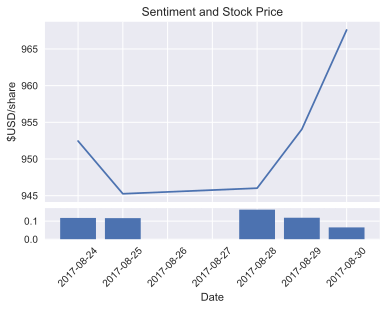

In [12]:
# now the graph...
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
plt.title('Sentiment and Stock Price')
plt.ylabel('$USD/share')
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

plt.xticks(rotation=45)
plt.xlabel('Date')

ax1.plot(df_tick_sent.index, df_tick_sent['4. close'])
# ax1.plot(df_tick.index, df_tick['100ma'])
ax2.bar(df_tick_sent.index, df_tick_sent['textblob_sent'])

# plt.savefig('Visuals/stockvsent.png', dpi=900, bbox_inches='tight')
plt.show()

#### Remove the weekends...

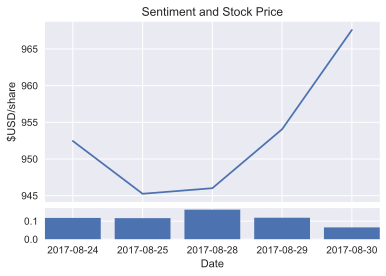

In [70]:
# now the graph...
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
plt.title('Sentiment and Stock Price')
plt.ylabel('$USD/share')
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

# manually create the x axis
d = pd.date_range(start="8/24/2017", end="8/30/2017", freq="B")
plt.xlabel('Date')

ax1.plot(range(df_tick_sent.index.size), df_tick_sent['4. close'])
ax2.bar(range(df_tick_sent.index.size), df_tick_sent['textblob_sent'])

# Align the axis labels with the spacing you've defined.
xticks = plt.xticks()[0]
xticklabels = [(d[0] + x).strftime('%Y-%m-%d') for x in xticks.astype(int)]
plt.xticks(xticks, xticklabels)
plt.autoscale(True, axis='x', tight=True)

# plt.savefig('Visuals/stockvsent.png', dpi=900, bbox_inches='tight')
plt.show()

### Now Sentiment v Stock graph of only classified articles...

In [13]:
df_econ = pd.read_csv('~/ds/data/nlp/Full-Economic-News-DFE-839861.csv', encoding='latin-1')
df_econ = df_econ[['relevance','headline']]
df_econ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 2 columns):
relevance    8000 non-null object
headline     8000 non-null object
dtypes: object(2)
memory usage: 125.1+ KB


In [14]:
# set the target
X = df_econ.headline
y = df_econ.relevance

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

# vectorize the text (ensure ONLY the text)
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)

# make sure to ONLY transform the test data
count_test = count_vectorizer.transform(X_test)
print(count_vectorizer.get_feature_names()[1000:1010])

['boosted', 'boosts', 'boot', 'booth', 'border', 'bored', 'born', 'borrow', 'borrowed', 'borrowers']


In [15]:
# test classification on econ docs
# instantiate the classifier
nb_classifier = MultinomialNB()

# fit the classifer to the training data
nb_classifier.fit(count_train, y_train)

# make prediction on transformed test data
pred = nb_classifier.predict(count_test)

# generate output of accuracy
metrics.accuracy_score(y_test, pred)

0.7965909090909091

In [16]:
# Vectorize the articles into a matrix
amznnews_matrix = count_vectorizer.transform(df_amznnews.headline_text)

# predict whether or not economically relevant based on previously fit model
amznnews_pred = nb_classifier.predict(amznnews_matrix)

In [17]:
# this returns a list of the indices where the tweet is related to economics
yes_ind = []
for ind, title in enumerate(amznnews_pred):
    if title == 'yes':
        yes_ind.append(ind)

# random sample to visually confirm...
print(yes_ind[5:10])
print(len(yes_ind))

[155, 156, 166, 180, 195]
218


In [18]:
# below I want the entire DF but it has DT index, not numbered index... maybe with iloc???
# df_amznnews_clsfd = [df_amznnews.isin()]

df_amznnews_clsfd = df_amznnews.iloc[yes_ind]
print(df_amznnews_clsfd.info())
print()
print(df_tick.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 381028 to 1130261
Data columns (total 10 columns):
publish_time     218 non-null datetime64[ns]
feed_code        218 non-null object
source_url       218 non-null object
headline_text    218 non-null object
textblob_sent    218 non-null float64
vader_sent       218 non-null object
vs_neg           218 non-null float64
vs_neu           218 non-null float64
vs_pos           218 non-null float64
vs_compound      218 non-null float64
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 18.7+ KB
None

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2017-08-24 to 2017-08-30
Data columns (total 5 columns):
1. open      5 non-null float64
2. high      5 non-null float64
3. low       5 non-null float64
4. close     5 non-null float64
5. volume    5 non-null float64
dtypes: float64(5)
memory usage: 400.0 bytes
None


In [19]:
# build new df from 'df_amznnews' so as to leave that available for other play.
df_amznnews_clsfd_2tick = df_amznnews_clsfd[['publish_time','textblob_sent', 'vs_compound']]
df_amznnews_clsfd_2tick.head()

,publish_time,textblob_sent,vs_compound
381028,2017-08-25 15:13:00,0.0,0.1779
381377,2017-08-25 15:15:00,0.0,0.1779
733,2017-08-24 00:04:00,0.0,0.1779
9551,2017-08-24 00:56:00,0.2,0.1779
16393,2017-08-24 01:35:00,0.2,0.1779


In [20]:
# set index as datetimeindex
df_amznnews_clsfd_2tick = df_amznnews_clsfd_2tick.set_index('publish_time')
df_amznnews_clsfd_2tick.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 218 entries, 2017-08-25 15:13:00 to 2017-08-29 16:42:00
Data columns (total 2 columns):
textblob_sent    218 non-null float64
vs_compound      218 non-null float64
dtypes: float64(2)
memory usage: 5.1 KB


In [21]:
# resample to align with ticker data
df_amznnews_clsfd_2tick = df_amznnews_clsfd_2tick[['textblob_sent', 'vs_compound']].resample('1D').mean()
# result?
print(df_amznnews_clsfd_2tick)
# print()
# print(np.log(df_amznnews_clsfd_2tick))

              textblob_sent  vs_compound
publish_time                            
2017-08-24         0.040221     0.174324
2017-08-25         0.022069     0.075840
2017-08-26         0.026190     0.128229
2017-08-27         0.042031     0.156500
2017-08-28         0.186635     0.220628
2017-08-29         0.059202     0.023010
2017-08-30         0.030994     0.075432


In [22]:
# plug in to df_tick
df_tick_clsfd_sent = df_tick.join(df_amznnews_clsfd_2tick)
df_tick_clsfd_sent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2017-08-24 to 2017-08-30
Data columns (total 7 columns):
1. open          5 non-null float64
2. high          5 non-null float64
3. low           5 non-null float64
4. close         5 non-null float64
5. volume        5 non-null float64
textblob_sent    5 non-null float64
vs_compound      5 non-null float64
dtypes: float64(7)
memory usage: 480.0 bytes


In [25]:
df_tick_clsfd_sent.head(10)

,1. open,2. high,3. low,4. close,5. volume,textblob_sent,vs_compound
2017-08-24,957.42,959.000,941.1400,952.45,5086748.0,0.040221,0.174324
2017-08-25,956.00,957.621,944.1000,945.26,3292776.0,0.022069,0.075840
2017-08-28,946.54,953.000,942.2500,946.02,2529087.0,0.186635,0.220628
2017-08-29,940.00,956.000,936.3300,954.06,2853972.0,0.059202,0.023010
2017-08-30,958.44,969.410,956.9062,967.59,2860718.0,0.030994,0.075432


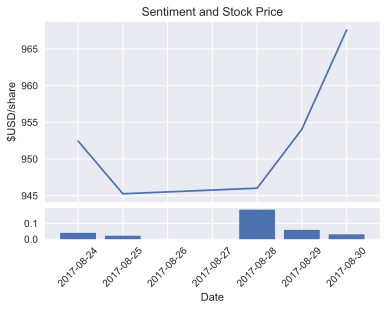

In [23]:
# now the graph...
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
plt.title('Sentiment and Stock Price')
plt.ylabel('$USD/share')
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

plt.xticks(rotation=45)
plt.xlabel('Date')

ax1.plot(df_tick_clsfd_sent.index, df_tick_clsfd_sent['4. close'])
# ax1.plot(df_tick.index, df_tick['100ma'])
ax2.bar(df_tick_clsfd_sent.index, df_tick_clsfd_sent['textblob_sent'])

# plt.savefig('Visuals/stockvsent_cld.png', dpi=900, bbox_inches='tight')
plt.show()

#### Testing plot adjustments

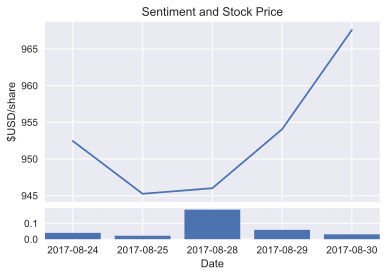

In [66]:
# now without labels (https://stackoverflow.com/questions/35397562/matplotlib-only-business-days-without-weekends-on-x-axis-with-plot-date)

# Classified graph with ATTEMPT to remove weekend days
# now the graph...
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
plt.title('Sentiment and Stock Price')
plt.ylabel('$USD/share')
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)

d = pd.date_range(start="8/24/2017", end="8/30/2017", freq="B")
close_price = df_tick_clsfd_sent['4. close']
sentiment = df_tick_clsfd_sent['textblob_sent']

ax1.plot(range(d.size), close_price)
# ax1.plot(df_tick.index, df_tick['100ma'])
ax2.bar(range(d.size), sentiment)

xticks = plt.xticks()[0]
xticklabels = [(d[0] + x).strftime('%Y-%m-%d') for x in xticks.astype(int)]
plt.xticks(xticks, xticklabels)
plt.autoscale(True, axis='x', tight=True)
plt.xlabel('Date')

# plt.savefig('Visuals/stockvsent_cld.png', dpi=900, bbox_inches='tight')
plt.show()

# So... in .plot x-vals need to simply be a ranges. The xticklabels are mapping 
# to equal intervals along the x val range. Not intuitive, but works when you
# want to break apart the plot and make it your own.

In [56]:
xticklabels

['2017-08-24',
 '2017-08-24',
 '2017-08-24',
 '2017-08-24',
 '2017-08-24',
 '2017-08-25']

In [57]:
len(v)

5

In [41]:
len(df_tick_clsfd_sent['4. close'])

5

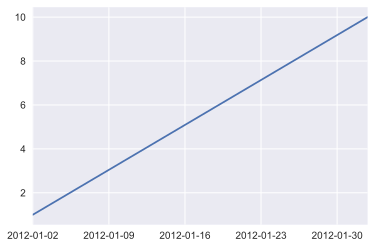

In [60]:
d = pd.date_range(start="1/1/2012", end="2/1/2012", freq="B")
v = np.linspace(1,10,len(d))

plt.plot(range(d.size), v)
xticks = plt.xticks()[0]
xticklabels = [(d[0] + x).strftime('%Y-%m-%d') for x in xticks.astype(int)]
plt.xticks(xticks, xticklabels)
plt.autoscale(True, axis='x', tight=True)

In [61]:
xticklabels

['2011-12-26',
 '2012-01-02',
 '2012-01-09',
 '2012-01-16',
 '2012-01-23',
 '2012-01-30',
 '2012-02-06']